# <a id='toc1_'></a>[Deep Learning CV Cheat Sheet](#toc0_)

This notebook contains information about some computer vision models and concepts. If you want to find some additional information or read the original paper, there are links to them.

**What emojis mean:** 

 👀 Link to video \
 📖 Link to paper or repository \
 📒 Pseudocode 

Hope you'll find it helpful🙂.

**Table of contents**<a id='toc0_'></a>    
- [Deep Learning CV Cheat Sheet](#toc1_)    
  - [YOLO](#toc1_1_)    
  - [Vision Transformer](#toc1_2_)    
    - [Usage](#toc1_2_1_)    
      - [Creating embeddings](#toc1_2_1_1_)    
      - [Creating Transformer](#toc1_2_1_2_)    
  - [CLIP/SigLIP](#toc1_3_)    
  - [DINO](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [8]:
import torch

torch.cuda.is_available()

True

<center><img src="image.jpg"></center>

<center>We will use this handsome fella for our code examples😺</center>

In [11]:
import torch
from torch import nn
from torch.nn import functional as F

from torchvision import transforms

## <a id='toc1_1_'></a>[YOLO](#toc0_)

**[📖Original paper](https://arxiv.org/abs/1506.02640)**

YOLO means You Only Look Once. It is one of the single stage algorithm along with SSD. There have been a lot of different version released by now, so we will only look at the core principles of this algorithm.

Architecture of YOLOv1:

<img src="images/YOLO_architecture.png" width=800>

YOLO has 24 convolutional layers, 4 max-pooling layers, and 2 fully connected layers.

The YOLOv1 algorithm follows an approach that can be broken down into several key steps. First, the input image is resized to a fixed dimension and divided into an S×S grid, where S=7 in the original implementation. Each grid cell becomes responsible for detecting objects whose centers fall within that cell's boundaries.

For each grid cell, the network predicts B bounding boxes (where B=2 in YOLOv1) along with confidence scores for each box. The confidence score reflects both the probability that the cell contains an object and how accurate the predicted bounding box is. Additionally, each grid cell predicts C class probabilities, where C represents the number of object classes in the dataset. These predictions are made simultaneously across all grid cells, enabling parallel processing and real-time inference

<img src="images/YOLO_steps.png" width=800>

### Usage

YOLOv5 training algorithm can be found [here](https://github.com/ultralytics/yolov5?tab=readme-ov-file).

The code below uses pretrained YOLOv5 from torch hub.

Using cache found in C:\Users\Dima/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-6-1 Python-3.12.10 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\Dima/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 512x512 1 cat
Speed: 6.1ms pre-process, 15.5ms inference, 140.5ms NMS per image at shape (1, 3, 640, 640)


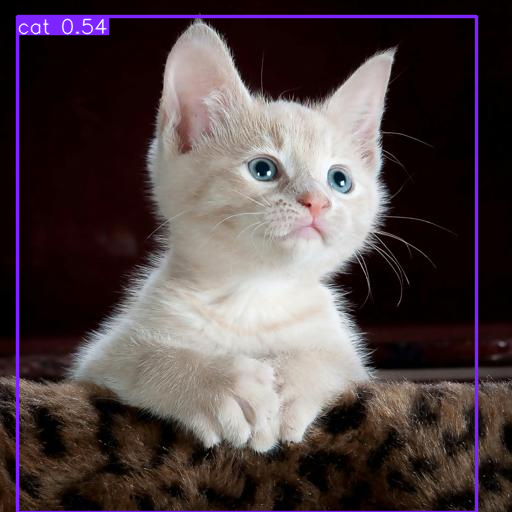

In [ ]:
import torch
from PIL import Image

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

img = Image.open("image.jpg")

# Inference
results = model([img])

# Results
results.print()
results.show()

## <a id='toc1_2_'></a>[Vision Transformer](#toc0_)

**[📖 Original paper](https://arxiv.org/abs/2010.11929)**

Vision Transformers utilize attention mechanism, by dividing initial image into patches with small size ($16 × 16$ in the original paper) and adding one additional patch. Those patches are then transformed into embeddings with positional encoding and passed into attention mechanism. In the end, additional patch is passed into classification head with softmax function to predict image's class.

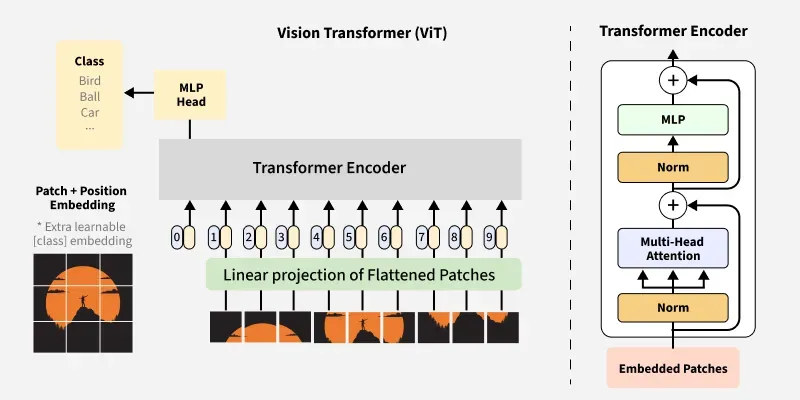

[👀 Here is a great video about vision transformers.](https://www.youtube.com/watch?v=vJF3TBI8esQ)

### <a id='toc1_2_1_'></a>[Usage](#toc0_)

#### <a id='toc1_2_1_1_'></a>[Creating embeddings](#toc0_)

Code is taken from [👀this video](https://www.youtube.com/watch?v=4XgDdxpXHEQ&t=1287s)

This code shows simplified process of creating the Embedded Patches. You can  

In [ ]:
def preprocess_image(image, image_size=224):
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(           # As for ImageNet
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    image_tensor = preprocess(image)
    #(3, 224, 224) --> unsqueeze --> (1, 3, 224, 224)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

image_tensor = preprocess_image(img)

embed_dim = 128             # number of dimentions in embeddings
patch_size = 16              # kernel size of patches (N × N)
image_size = 224
num_patches = (image_size // patch_size) ** 2

with torch.no_grad():
    patch_embedding = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
    patches = patch_embedding(image_tensor)

patches.shape, num_patches

(torch.Size([1, 128, 14, 14]), 196)

Now we need to create positional embeddings. Here, embeddings are created by simply passing each patch position id into nn.Embedding.

For additional info about positional embeddings you can check [📖RoPE](https://arxiv.org/abs/2104.09864v5) or [📖Sinusoidal positional encoding](https://arxiv.org/abs/1706.03762).

In [16]:
position_embedding = nn.Embedding(num_patches, embed_dim)
position_ids = torch.arange(num_patches).expand((1, -1))

position_ids.shape

torch.Size([1, 196])

The next step is flattening our embeddings as shown below:

<kbd><img src="images/ViT_embed_b.png" alt="Embeddings before flattening" style="width: 200px;"/></kbd> => <kbd><img src="images/ViT_embed_a.png" alt="Embeddings after flattening" style="width: 500px;"/></kbd>

These pictures illustrate image with $8×8$ embeddings of unknown kernel size being flattened.

In [ ]:
# after flatten (1, embed_dim, num_patches)
embeddings = patches.flatten(start_dim=2, end_dim=-1)
# (1, embed_dim, num_patches) -> (1, num_patches, embed_dim)
embeddings = embeddings.transpose(1,2)

embeddings = embeddings + position_embedding(position_ids)

embeddings.shape

torch.Size([1, 196, 128])

This is how to create simple embeddings, but it is better to implement this algorithm to the model layer.

#### <a id='toc1_2_1_2_'></a>[Creating Transformer](#toc0_)

Code taken from [👀this video](https://www.youtube.com/watch?v=j3VNqtJUoz0&t=785s) with some minor adjustments.

We will use embeddings we created earlier as an input for created transformer.

In [18]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

In [19]:
Attention(dim=128, n_heads=4, dropout=0.)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [20]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [21]:
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [22]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [23]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [24]:
residual_att = ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.))
residual_att(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [29]:
class ViT(nn.Module):
    def __init__(self, ch=3, img_size=144, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=37, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, x):
        # Get patch embedding vectors
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = self.cls_token.repeat([b, 1, 1])
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])


model = ViT(img_size=224, patch_size=16, emb_dim=128)
print(model)
model(embeddings)


ViT(
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
            )
            (q): Linear(in_features=128, out_features=128, bias=True)
            (k): Linear(in_features=128, out_features=128, bias=True)
            (v): Linear(in_features=128, out_features=128, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=128, out_features=128, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.1, inplace=False)
            (3): Linear(in_features=128, out_features=128, bias=True)
            (4): Dropout

tensor([[ 0.2663, -0.1785, -0.2706,  0.1151,  0.1060, -0.0698, -0.4864,  0.2478,
          1.4254, -0.6733,  0.1979,  0.1400,  0.3344,  0.3016, -0.3333, -0.1853,
          0.0738, -0.4719, -1.2295,  0.1988, -0.6769, -0.0423, -0.2412, -0.3148,
         -0.0596,  0.0259,  0.8898,  0.6839,  1.0721,  0.3769, -0.2216,  0.1995,
         -0.7524,  0.5141, -0.6700, -1.4294,  0.4376]],
       grad_fn=<AddmmBackward0>)

Done! We can change different hyper parameters like out_dim or img_size to better suit our needs🙂

## <a id='toc1_3_'></a>[CLIP/SigLIP](#toc0_)

## <a id='toc1_4_'></a>[DINO](#toc0_)

**[📖 Original Facebook Research repository](https://github.com/facebookresearch/dino)**

Dino is a self-supervised vision transformer that uses 2 models with the same architecture as student and teacher and utilizes data augmentation from [📖BYOL](https://arxiv.org/abs/2006.07733) paper.

In the beginning, augmentations create 2 crops of the images, that contain 50% or more of the initial pics and several other images, that contain less area. Those images are then passed into models, but teacher only takes larger crops whereas student gets all types of crops. During training, teacher model generates from student and updates its parameters with EMA from student model. In the end, there is a softmax function that has lower temperature parameter for teacher, so that difference between predicted values if bigger => model is more "certain".

Here is the image from original paper:

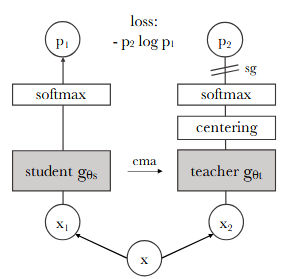

📒Pseudocode for DINO model training, taken from [original publication](https://arxiv.org/pdf/2104.14294):

```Python
# gs, gt: student and teacher networks
# C: center (K)
# tps, tpt: student and teacher temperatures
# l, m: network and center momentum rates
gt.params = gs.params
for x in loader: # load a minibatch x with n samples
    x1, x2 = augment(x), augment(x) # random views
    s1, s2 = gs(x1), gs(x2) # student output n-by-K
    t1, t2 = gt(x1), gt(x2) # teacher output n-by-K
    loss = H(t1, s2)/2 + H(t2, s1)/2
    loss.backward() # back-propagate
    # student, teacher and center updates
    update(gs) # SGD
    gt.params = l*gt.params + (1-l)*gs.params
    C = m*C + (1-m)*cat([t1, t2]).mean(dim=0)
def H(t, s):
    t = t.detach() # stop gradient
    s = softmax(s / tps, dim=1)
    t = softmax((t - C) / tpt, dim=1) # center + sharpen
    return - (t * log(s)).sum(dim=1).mean()
```
